## Description

We have been asked to evaluate the performance of a store trial which was performed in stores 77, 86 and 88.

We need to create a measure to compare different control stores to each of the trial stores and choose 3 control stores.

Once having selected control stores, we need to compare each trial and control pair during the trial period. We need to test if total sales are significantly different in the trial period and if so, check if the driver of change is more purchasing customers or more purchases per customers etc.

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy import stats

#  Loading and Checking data

In [2]:
data = pd.read_csv('data/QVI_data.csv')
data

,LYLTY_CARD_NBR,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,2018-10-17,1,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,NATURAL,YOUNG SINGLES/COUPLES,Premium
1,1002,2018-09-16,1,2,58,Red Rock Deli Chikn&Garlic Aioli 150g,1,2.7,150,RRD,YOUNG SINGLES/COUPLES,Mainstream
2,1003,2019-03-07,1,3,52,Grain Waves Sour Cream&Chives 210G,1,3.6,210,GRNWVES,YOUNG FAMILIES,Budget
3,1003,2019-03-08,1,4,106,Natural ChipCo Hony Soy Chckn175g,1,3.0,175,NATURAL,YOUNG FAMILIES,Budget
4,1004,2018-11-02,1,5,96,WW Original Stacked Chips 160g,1,1.9,160,WOOLWORTHS,OLDER SINGLES/COUPLES,Mainstream
...,...,...,...,...,...,...,...,...,...,...,...,...
264829,2370701,2018-12-08,88,240378,24,Grain Waves Sweet Chilli 210g,2,7.2,210,GRNWVES,YOUNG FAMILIES,Mainstream
264830,2370751,2018-10-01,88,240394,60,Kettle Tortilla ChpsFeta&Garlic 150g,2,9.2,150,KETTLE,YOUNG FAMILIES,Premium
264831,2370961,2018-10-24,88,240480,70,Tyrrells Crisps Lightly Salted 165g,2,8.4,165,TYRRELLS,OLDER FAMILIES,Budget
264832,2370961,2018-10-27,88,240481,65,Old El Paso Salsa Dip Chnky Tom Ht300g,2,10.2,300,OLD,OLDER FAMILIES,Budget


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264834 entries, 0 to 264833
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   LYLTY_CARD_NBR    264834 non-null  int64  
 1   DATE              264834 non-null  object 
 2   STORE_NBR         264834 non-null  int64  
 3   TXN_ID            264834 non-null  int64  
 4   PROD_NBR          264834 non-null  int64  
 5   PROD_NAME         264834 non-null  object 
 6   PROD_QTY          264834 non-null  int64  
 7   TOT_SALES         264834 non-null  float64
 8   PACK_SIZE         264834 non-null  int64  
 9   BRAND             264834 non-null  object 
 10  LIFESTAGE         264834 non-null  object 
 11  PREMIUM_CUSTOMER  264834 non-null  object 
dtypes: float64(1), int64(6), object(5)
memory usage: 24.2+ MB


no missing values is already great! Now let's check for anomalies

## Anomalies

<Axes: >

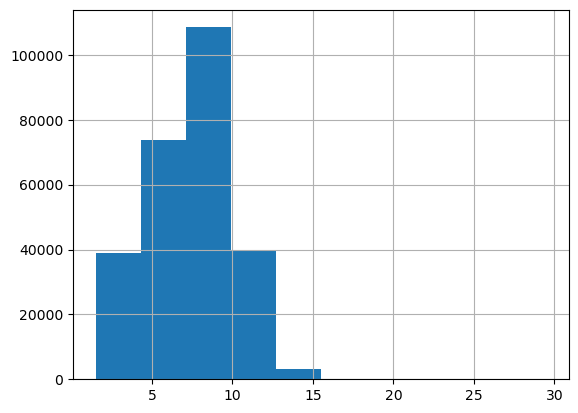

In [4]:
data['TOT_SALES'].hist()

<Axes: >

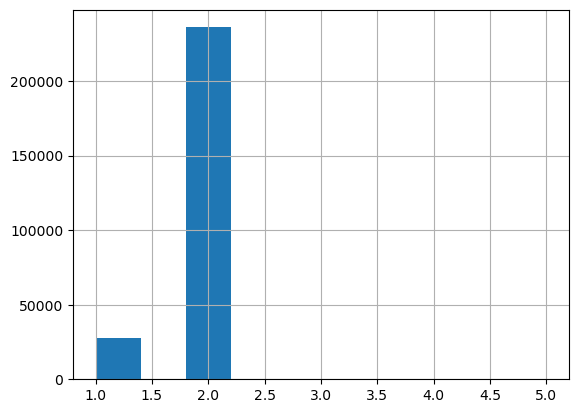

In [5]:
data['PROD_QTY'].hist()

Distribution looks ok at first glance. Now let's move on to learning more about stores.

## Stores

In [6]:
data['STORE_NBR'].value_counts()

226    2020
88     1873
93     1832
165    1819
237    1785
       ... 
206       2
31        2
252       2
76        1
92        1
Name: STORE_NBR, Length: 272, dtype: int64

In [7]:
data['STORE_NBR'].value_counts().describe()

count     272.000000
mean      973.654412
std       587.775315
min         1.000000
25%       528.750000
50%       679.000000
75%      1525.250000
max      2020.000000
Name: STORE_NBR, dtype: float64

<Axes: >

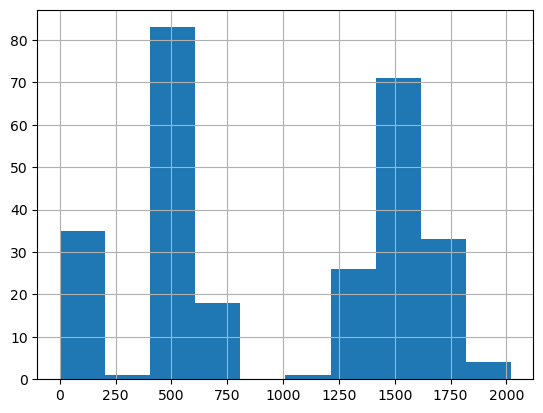

In [8]:
data['STORE_NBR'].value_counts().hist()

Here we can see bimodal distribution. That could on one hand simplify searching for corresponding control stores. I believe we can without fear split the data in 2 parts an work with them separately since our goal is not analysis of each store but finding bescontrol store for each trial store. 

## Total sales overview

Now let's look at time series plot of purchases. 

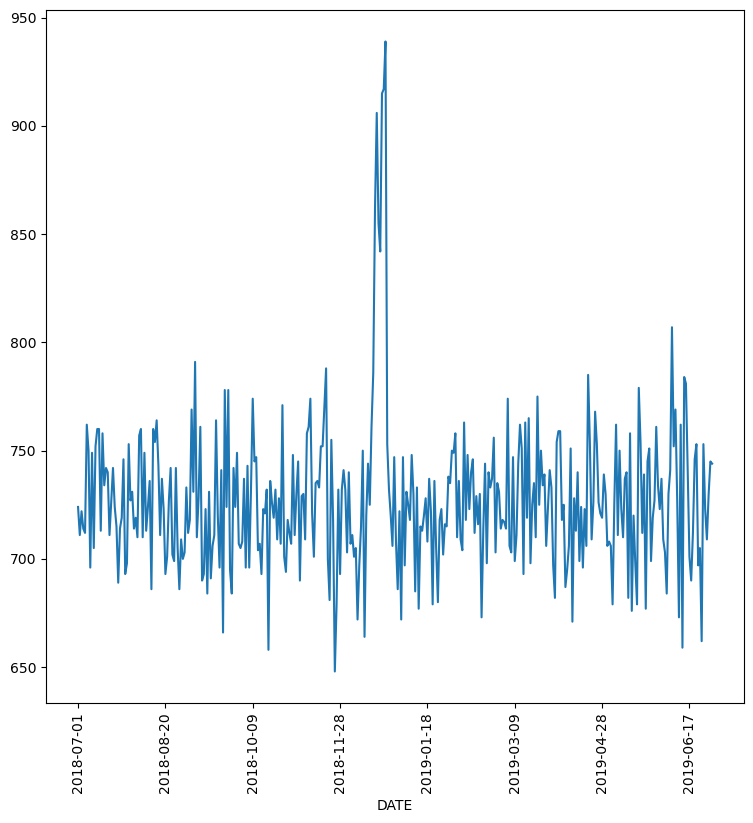

In [9]:
dates = data.groupby('DATE')['STORE_NBR'].count()
dates.sort_values(ascending = True)
dates.plot(figsize = (9,9))
plt.xticks(rotation = 90)
plt.show()

Looks like we have 1 year Dataframe. 

Some Christmas/New Year sales increase we can see. Also there's some volatility. It could be seasonalty (weekly? monthly?) as well, we need to dig deeper if we want to check this. 

Also I gues we have to maybe sort all values in a timeline order. Then we could maybe aggregate all the data by day/store/ 

365 days * 272 stores = 99280 aggregated columns let's see what we have now

In [10]:
print(data.groupby(['DATE','STORE_NBR'])['PROD_QTY'].sum())

DATE        STORE_NBR
2018-07-01  1             2
            2             3
            3             2
            4             9
            5             4
                         ..
2019-06-30  266           1
            268           3
            269          10
            271           8
            272           4
Name: PROD_QTY, Length: 78641, dtype: int64


It won't be much longer then it already is. However to simplify everything we might probably want to select the shops we want to delete already now. Or not? Let's look at trial stores first and see what we can understand. 

## Taking a look at trial stores

In [11]:
trial_stores = [77, 86, 88]

In [12]:
indicators = ['PROD_QTY', 'TOT_SALES', 'PACK_SIZE']

In [13]:
for i in trial_stores:
    print(data[data['STORE_NBR']==i][indicators].describe())

         PROD_QTY   TOT_SALES   PACK_SIZE
count  563.000000  563.000000  563.000000
mean     1.548845    5.399645  178.772647
std      0.532580    2.619975   55.865607
min      1.000000    1.500000   70.000000
25%      1.000000    3.400000  150.000000
50%      2.000000    5.200000  175.000000
75%      2.000000    7.200000  175.000000
max      5.000000   25.500000  380.000000
          PROD_QTY    TOT_SALES    PACK_SIZE
count  1538.000000  1538.000000  1538.000000
mean      1.993498     6.915052   177.393368
std       0.239190     2.303514    57.725141
min       1.000000     1.800000    70.000000
25%       2.000000     5.400000   150.000000
50%       2.000000     6.600000   170.000000
75%       2.000000     8.800000   175.000000
max       5.000000    16.800000   380.000000
          PROD_QTY    TOT_SALES    PACK_SIZE
count  1873.000000  1873.000000  1873.000000
mean      1.985051     8.720368   183.349172
std       0.203576     1.763947    71.139450
min       1.000000     3.250000   110

* 77 - not a lot of sales - 563 for the year, 1.5 packs average, 5.4 Usd - mean purchase
* 86 - a lot of sales - 1538 for the year, 2 packs average, 6.9 Usd - mean purchase
* 88 - a lot of sales 1873 for the year, 2 packs average, 8.7 Usd - mean purchase

pack sizes are more or less equal

So what's the plan? 
We need to find a corresponding control store for each trial store. Normally I would add some parameters and maybe split and use some clusterization or nearest neighbors method. (I even could split our dataset in 2 parts so that it would accelerate data processing in case we use hard models like etna clusterization in data series format). So the thing is if we should judge by aggregated numbers or by time series. 

However I'd like to raise my concerns first. I believe if we compare data as it is, we will have data leaks. So I'd like to somehow exclude the test period to avoid this data leakage. Trial layout was from start of February 2019 till the end of April. (02.19-04.19). So the question is - if we exclude trial layout period data what we do with May and June? 
I think I'd like to just delete this data beceasue 2 month is not much and the are already after the trial period - so not sure if there will be any aftereffect. 

# Dropping non-relevant periods and reassessment. 

In [17]:
data['DATE'] = pd.to_datetime(data['DATE'])

In [18]:
data.dtypes

LYLTY_CARD_NBR               int64
DATE                datetime64[ns]
STORE_NBR                    int64
TXN_ID                       int64
PROD_NBR                     int64
PROD_NAME                   object
PROD_QTY                     int64
TOT_SALES                  float64
PACK_SIZE                    int64
BRAND                       object
LIFESTAGE                   object
PREMIUM_CUSTOMER            object
dtype: object

In [20]:
#data

In [35]:
df = data[data['DATE']< '2019-02-01'].copy()

In [36]:
display(df.sort_values(by='DATE', ascending=True))

,LYLTY_CARD_NBR,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER
76844,80047,2018-07-01,80,78468,44,Thins Chips Light& Tangy 175g,2,6.6,175,THINS,OLDER SINGLES/COUPLES,Budget
194872,199302,2018-07-01,199,198907,23,Cheezels Cheese 330g,2,11.4,330,CHEEZELS,OLDER SINGLES/COUPLES,Mainstream
9344,10089,2018-07-01,10,9563,102,Kettle Mozzarella Basil & Pesto 175g,2,10.8,175,KETTLE,YOUNG FAMILIES,Premium
83528,86187,2018-07-01,86,85295,74,Tostitos Splash Of Lime 175g,2,8.8,175,TOSTITOS,YOUNG SINGLES/COUPLES,Mainstream
71315,73443,2018-07-01,73,72807,54,CCs Original 175g,1,2.1,175,CCS,OLDER SINGLES/COUPLES,Budget
...,...,...,...,...,...,...,...,...,...,...,...,...
169827,172099,2019-01-31,172,173347,14,Smiths Crnkle Chip Orgnl Big Bag 380g,2,11.8,380,SMITHS,OLDER SINGLES/COUPLES,Budget
222366,226141,2019-01-31,226,226974,24,Grain Waves Sweet Chilli 210g,2,7.2,210,GRNWVES,YOUNG FAMILIES,Premium
123986,123106,2019-01-31,123,126541,25,Pringles SourCream Onion 134g,2,7.4,134,PRINGLES,RETIREES,Premium
6759,7154,2019-01-31,7,6925,9,Kettle Tortilla ChpsBtroot&Ricotta 150g,1,4.6,150,KETTLE,OLDER FAMILIES,Budget


# Part 3

In [14]:
## ideas for metrics:
#customer spending per chip packet
#perchases per customer


Possible params: 
- total sales revenue
- total number of customers
- average number of transactions per customer